#### <b> Goal: To test whether the ocean drives the atmosphere or the other way round in the Gulf of Mexico. We will do this by plotting correlations between: (i) SST and turbulent heat flux (THF) at the surface; and (ii) d(SST)/dt and THF. </b>

#### <b> Principle: If the atmosphere drives the ocean, correlation in (ii) at zero lag has maximum magnitude as more heat into the ocean implies greater rate of warming (i.e., d(SST)/dt). Correlation in (i), on the other hand, is zero at zero lag as SST lags the THF and will build up gradually over time.  </b>

#### <b> If the ocean drives the atmosphere, the situation reverses. The correlation in (i) has maximum magnitude at zero lag while the correlation in (ii) has an anti-symmetric profile about zero lag. 
    
#### <b> Data: 9-year coupled simulation (ROMS + WRF) of the Gulf of Mexico with ocean/atmosphere resolution of 3 km. Only years 2-9 used for analysis. </b> 

#### <b> Import modules required for calculations </b> 

In [ ]:
import sys
import os 

import gc

import time
import netCDF4
#import h5netcdf
import glob

import warnings

import cf_xarray
#import xcmocean
import RePlots as rp

import scipy
from scipy import stats, signal #Required for detrending data and computing regression
from scipy.stats import t
from scipy.optimize import curve_fit
from statsmodels.tsa import stattools

from rechunker import rechunk

import math
import xarray as xr
import xroms
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry.polygon import LinearRing

import pandas as pd

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo

import zarr

import xscale

import dask
from dask.distributed import Client
from dask import delayed # to allow parallel computation
from distributed import Client
from dask_jobqueue import SLURMCluster

from dask.distributed import progress
from dask.diagnostics import ProgressBar
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler

xr.set_options(display_style="html")

#xr.show_versions()

#### <b> Plotting parameters and paths </b>

In [2]:
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rc('figure',titlesize=16)
mpl.rcParams['lines.linewidth'] = 1


#### <b> Constants </b>

In [3]:
grav=9.814; R0=1027; Cp =4200;
secindays=86400;

#### <b> Important Dask setting for efficient chunking of arrays </b>

In [ ]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

#### <b> Launch dask cluster with 18 nodes and 384 Gb total memory </b>

In [ ]:
cluster = SLURMCluster(cores=18, processes=18, memory="384GB",queue="short",
                       walltime="01:30:00")
print(cluster.job_script())
cluster.scale(18)
client = Client(cluster)

#### <b> Define path to cartopy shapefiles for map projections</b>

In [16]:
cartopy.config['pre_existing_data_dir']='./cartopy/shapefiles' + '/natural_earth/physical/'

proj = cartopy.crs.PlateCarree()  # to match lon/lat

#### <b> Build the list of file names </b>

In [6]:
outdir='./'
fname='cmpr*ocn*hi*201[1-8]-*nc'

files = sorted(glob.glob(outdir+fname))

#### <b> Select variables of interest, only this list will be read in from files to speed up processing.  </b>
#### <b> Here we are selecting: SST, latent heat flux, sensible heat flux and SSH. </b>

In [7]:
ds=xr.open_dataset(files[0],chunks='auto')#,engine='scipy')
varlist=list(ds.variables)

droplist=['ocean_time','lon_rho','lat_rho','s_w','s_rho']

vars=['temp','sensible','latent','zeta']
droplist.extend(vars)
for i in droplist:
    varlist.remove(i)

nx_global = len(ds.xi_rho); ny_global = len(ds.eta_rho)
nz_rho=len(ds.s_rho); nz_w = len(ds.s_w)

489 655


#### <b> Read in files from years 2-9 but only the subset of variables defined above. </b>
#### <b> The files are read into an Xarray dataset object. </b>

In [10]:
pivot='./cmpr_GOM_9k_nature_copernicus.ocn.hi.2014-12-06_03:00:00.nc'
isplit=files.index(pivot)

In [11]:
chunks='auto'

ds1=xr.open_mfdataset(files[0:isplit],parallel=True,data_vars='minimal',concat_dim='time',
           chunks=chunks,coords='minimal',compat='override',drop_variables=varlist)

ds1=ds1.isel(s_rho=-1,s_w=-1).copy().squeeze(drop=True)

ds1=ds1.drop_vars(['s_w','s_rho'])

chunks='auto'

scalar_vars=['ntsDIA','ndefDIA','ntsAVG','ndefAVG','nDIA','nAVG']
varlist.extend(scalar_vars)

ds2=xr.open_mfdataset(files[isplit:],parallel=True,data_vars='minimal',concat_dim='time',
           chunks=chunks,coords='minimal',compat='override',drop_variables=varlist)

ds2=ds2.isel(s_rho=-1,s_w=-1).copy().squeeze(drop=True)

ds2=ds2.drop_vars(['s_w','s_rho'])

dim='ocean_time'

ds=xr.concat([ds1,ds2],dim)

#### <b> Copy the variables from the dataset into Xarray dataarrays and drop unnecessary coordinates.  </b>
#### <b> The variable THF (turbulent heat flux) contains the sum of the latent and sensible heat fluxes at the air-sea interface. </b> 

In [14]:
sst = ds.temp.copy().rename('sst')
thf = (ds.latent.copy() + ds.sensible.copy()).rename('thf')
ssh = ds.zeta.copy().rename('ssh')

drop_zcoords = ['z_w','z_rho','z_rho0','z_w0','s_w','s_rho']

#### <b> Plot below shows the standard deviation of SSH over years 2-9.</b>

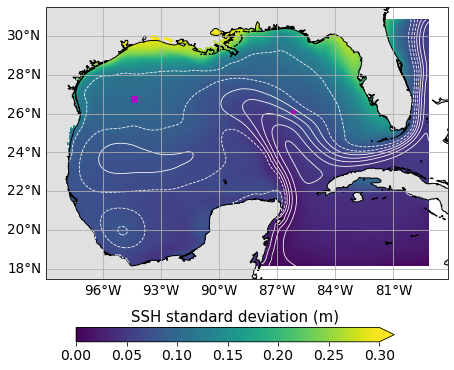

In [17]:
outdir='./time_means/'
fname='GoM_2011_2018_timemean.nc'
ds_means=xr.open_dataset(outdir + fname)

ssh_mean=ds_means['ssh_mean_daily']
ssh_std=ds_means['sst_std_daily']

locs=[(325,125), (300,410)]

fig,axs=plt.subplots(1,1,figsize=(13,5),subplot_kw=dict(projection=proj))

mark=['s','*']

axs.add_feature(cf.COASTLINE) 
axs.add_feature(cf.LAND, color="lightgrey", alpha=0.7)
ssh_mean.cf.plot.contour(ax=axs,x='longitude',y='latitude',colors='w',
                         levels=np.arange(-0.5,0.6,0.1),linewidths=0.8)
fg=ssh_std.cf.plot(ax=axs,x='longitude',y='latitude',add_colorbar=False,
                   cmap=plt.cm.viridis)
gl=axs.gridlines(xformatter=LONGITUDE_FORMATTER,yformatter=LATITUDE_FORMATTER,
                 draw_labels=True)
gl.xlabel_style = {'size': 13.5, 'color': 'black'}
gl.ylabel_style = {'size': 13.5, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
for i in range(len(locs)):
        axs.scatter(ds.lon_rho[locs[i][0],locs[i][1]],ds.lat_rho[locs[i][0],locs[i][1]],
                    color='m',marker=mark[i])

cmin=0;cmax=0.3
norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
cax = fig.add_axes([0.33, -0.05, 0.34, 0.04])
cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.viridis, norm=norm,
                               orientation='horizontal',extend='max')
cb.ax.tick_params(labelsize=14.0)
cb.ax.set_title(r'SSH standard deviation (m)',fontdict={'fontsize':15});

fig.set_facecolor("w")

#### <b> Resample 3-hourly model output to daily averages for subsequent analysis </b>

In [18]:
chunks='auto'

thf_daily= thf.chunk(chunks).resample(ocean_time='1D').mean(skipna=True,
                                                            keep_attrs=True).persist()

sst_daily= sst.chunk(chunks).resample(ocean_time='1D').mean(skipna=True,
                                                            keep_attrs=True).persist()

#### <b> Remove daily climatology from the SST and THF signals. </b>

In [19]:
sst_daily_clim=sst_daily.groupby('ocean_time.dayofyear').mean('ocean_time').compute()
thf_daily_clim=thf_daily.groupby('ocean_time.dayofyear').mean('ocean_time').compute()

sst_daily = sst_daily.groupby('ocean_time.dayofyear')-sst_daily_clim
thf_daily = thf_daily.groupby('ocean_time.dayofyear')-thf_daily_clim

#### <b> Routine to detrend signal in time before computing correlation between SST and THF. </b>

In [20]:
def detrend_dim_orig(da, dim, deg=1):
    # detrend along a single dimension
    
    # Original Abernathey version   
    p = da.polyfit(dim=dim, deg=deg,skipna=True)

    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    
    return da - fit 

#### <b> Detrend the SST signal </b>

In [23]:
dim = 'ocean_time'

chunks=dict(ocean_time=-1,eta_rho=100,xi_rho=100)

half_win = 8

field = sst_daily.chunk(chunks)

field1_detrend = detrend_dim_orig(field,dim,deg=1)

#### <b> Detrend the THF signal </b>

In [24]:
field = thf_daily.chunk(chunks)

field2_detrend = detrend_dim_orig(field,dim,deg=1)

#### <b> Select the higher frequency (21 days) for band-pass operation </b>

In [25]:
# For daily-averaged files
half_win_lp = 10; # for 21 days ~ corresponds approx. to decorrelation timescale (see cell above)

half_win=half_win_lp

fac=4

chunks='auto'

sst_lp = field1_detrend.chunk(chunks).rolling(ocean_time=2*half_win+1,center=True) \
           .mean(skipna=True)
thf_lp = field2_detrend.chunk(chunks).rolling(ocean_time=2*half_win+1,center=True) \
           .mean(skipna=True)

#### <b> Select the lower frequency (3 months) for band-pass operation </b>

In [26]:
# For daily-averaged files
half_win_hp = 45; # ~3 months (seasonal cycle)

half_win=half_win_hp

chunks='auto'

sst_hp = field1_detrend.chunk(chunks).rolling(ocean_time=2*half_win+1,center=True) \
           .mean(skipna=True)
thf_hp = field2_detrend.chunk(chunks).rolling(ocean_time=2*half_win+1,center=True) \
           .mean(skipna=True)

#### <b> The cell below contains the signal with variability between 21 days and 3 months (subseasonal variability) </b>

In [27]:
chunks={}

half_win=half_win_hp

sst_bp = (sst_lp.chunk(chunks).isel(ocean_time=slice(half_win,-half_win)) \
        - sst_hp.chunk(chunks).isel(ocean_time=slice(half_win,-half_win)) )
thf_bp = (thf_lp.chunk(chunks).isel(ocean_time=slice(half_win,-half_win)) \
        - thf_hp.chunk(chunks).isel(ocean_time=slice(half_win,-half_win)) )

#### <b> Compute the time derivative of the above band-passed signal </b>

In [28]:
dsstdt_bp = xr.DataArray(np.zeros(sst_bp.shape),dims=sst_bp.dims,
                         coords=sst_bp.coords).rename('DSSTDT')
dsstdt_bp.attrs['units']='DegC/s'
dsstdt_bp.attrs['long_name']='Rate of change of SST'

# For daily-averaged files
dt_center  = 2*secindays # 2 days
dt_oneside = 1*secindays  # 1 day

dsstdt_bp = (sst_bp.shift(ocean_time=-1) - 
             sst_bp.shift(ocean_time= 1)) / dt_center
dsstdt_bp[ 0,:,:] = (sst_bp[ 1,:,:] - sst_bp[ 0,:,:]) / dt_oneside
dsstdt_bp[-1,:,:] = (sst_bp[-1,:,:] - sst_bp[-2,:,:]) / dt_oneside        

#### <b> Box width for spatial averaging of the band-passed signal. The box width here is 200 km.</b>

In [30]:
#box=dict(eta_rho=25,xi_rho=25) # ~ 75 km 
#box=dict(eta_rho=33,xi_rho=33) # ~ 100 km 
#box=dict(eta_rho=49,xi_rho=49) # ~ 150 km 
box=dict(eta_rho=67,xi_rho=67) # 200 km
#box=dict(eta_rho=17,xi_rho=17) # 

#### <b> Spatially smooth SST and THF over 200 km </b>

In [31]:
sst_bp_xylp=sst_bp.rolling(dim=box,center=True).mean().persist()
thf_bp_xylp=thf_bp.rolling(dim=box,center=True).mean().persist()

#### <b> Compute the time derivative of the above band-passed signal </b>

In [32]:
dsstdt_bp_xylp = xr.DataArray(np.zeros(sst_bp_xylp.shape),
                              dims=sst_bp_xylp.dims,
                              coords=sst_bp_xylp.coords).rename('DSSTDT')
dsstdt_bp_xylp.attrs['units']='DegC/s'
dsstdt_bp_xylp.attrs['long_name']='Rate of change of SST'

# For daily-averaged files
dt_center  = 2*secindays # 2 days
dt_oneside = 1*secindays  # 1 day

dsstdt_bp_xylp = (sst_bp_xylp.shift(ocean_time=-1) - 
                  sst_bp_xylp.shift(ocean_time= 1)) / dt_center
dsstdt_bp_xylp[ 0,:,:] = (sst_bp_xylp[ 1,:,:] - sst_bp_xylp[ 0,:,:]) / dt_oneside
dsstdt_bp_xylp[-1,:,:] = (sst_bp_xylp[-1,:,:] - sst_bp_xylp[-2,:,:]) / dt_oneside        

#### <b> Routine to compute the covariance </b>

In [33]:
def covariance(x, y, dim=None):
    valid_values = x.notnull() & y.notnull()
    valid_count = valid_values.sum(dim)

    demeaned_x = (x - x.mean(dim)).fillna(0)
    demeaned_y = (y - y.mean(dim)).fillna(0)
    
    return xr.dot(demeaned_x, demeaned_y, dims=dim) / valid_count

def correlation(x, y, dim=None):
    # dim should default to the intersection of x.dims and y.dims
    return covariance(x, y, dim) / (x.std(dim) * y.std(dim))

#### <b> Routine to compute the lead-lag correlation </b>

In [34]:
def lag_linregress_3D_orig(x, y, lagx=0, lagy=0,pcrit=0.05):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions
    (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept 
    will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard
    error on regression between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy
    shifting y, with the specified lag amount. 
    """     
    
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
        
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). 
        #Hence it needs to be dropped
#        x   = x.shift(time = lagx).dropna(dim='time')
        if (lagx > 0):
            x = x.shift(time=lagx).isel(time=slice(lagx,None))
            y = y.isel(time=slice(lagx,None))
        else:
            x = x.shift(time=lagx).isel(time=slice(None,lagx))
            y = y.isel(time=slice(None,lagx))
            
        #Next important step is to re-align the two datasets so that y adjusts 
        #to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = lagy).dropna(dim='time')
        x,y = xr.align(x,y)
            
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    cor   = cov/(xstd*ystd)
    
    tstats = cor*np.sqrt(n-2)/np.sqrt(1.0-cor**2)
    
    pval = xr.DataArray((t.sf(np.abs(tstats), n-2))*2, 
                        dims=cor.dims, coords=cor.coords)
    
    cor  = xr.DataArray(np.where(pval >= 0.05,0,cor),
                        dims=pval.dims,coords=pval.coords)
  
    return cor,pval

#### <b> Use the above routine to calculate covariance at +/- 1 week lag </b>

In [35]:
# CHECK CORRELATIONS/P-VALUES OBTAINED FROM USER-DEFINED FUNCTION AND INTRINSIC 
# FUNCTIONS DEFINED IN THE STATS MODULE

# daily-averaged values
lag_check=7 # 1 week

jcheck=325; icheck=125;

chunks={}

field = sst_bp_xylp
#field = sst_bp - -sst_bp_xylp
#field = dsstdt_bp - dsstdt_bp_xylp
#field = dsstdt_bp_xylp
A=field.chunk(chunks).rename(dict(ocean_time='time')); 

#field = thf_bp - thf_bp_xylp
field = thf_bp_xylp
B=field.chunk(chunks).rename(dict(ocean_time='time'));

pcrit = 0.05;

r0, p0        = lag_linregress_3D_orig(A,B,         0,0,pcrit)
rplus,pplus   = lag_linregress_3D_orig(A,B, lag_check,0,pcrit)
rminus,pminus = lag_linregress_3D_orig(A,B,-lag_check,0,pcrit)

r0=r0.compute(); p0=p0.compute()
rplus = rplus.compute(); pplus=  pplus.compute()
rminus=rminus.compute(); pminus=pminus.compute()

r0=r0.rename('R_0lag');                p0=p0.rename('pval_0lag')
rplus=  rplus.rename('R_1w_lead');  pplus= pplus.rename('pval_1w_lead')
rminus=rminus.rename('R_1w_lag' ); pminus=pminus.rename('pval_1w_lag')

pcrit = 0.05

for var in [rplus,rminus,r0]:
    if 'grid' in var.attrs: del var.attrs['grid']
    
lag = -lag_check;
#lag = 0;

if lag >= 0:  # Leads (lag>=0)
    rc,pc=stats.pearsonr(A[:,jcheck,icheck].shift(time= lag).isel(time=slice(lag,None)).values,
                         B[:,jcheck,icheck].isel(time=slice(lag,None)).values)
else:  # Lags (lag<0)
    rc,pc=stats.pearsonr(A[:,jcheck,icheck].shift(time= lag).isel(time=slice(None,lag)).values,
                         B[:,jcheck,icheck].isel(time=slice(None,lag)).values)
    
print('From stats.pearson  : ',  'R:', rc, 'P-val: ', pc)

if lag > 0:
    print('From user subroutine: ', 'R:', rplus[jcheck,icheck].values, ', P-val: ', 
          pplus[jcheck,icheck].values)
elif lag==0:
    print('From user subroutine: ', 'R:', r0[jcheck,icheck].values, ', P-val: ', 
          p0[jcheck,icheck].values)    
else:
    print('From user subroutine: ', 'R:',rminus[jcheck,icheck].values, ', P-val: ',
          pminus[jcheck,icheck].values)    

From stats.pearson  :  R: 0.3514865994674572 P-val:  9.25128033201134e-83
From user subroutine:  R: 0.3514865994674574 , P-val:  9.251280332023104e-83


#### <b> Define continuous lags for obtaining smooth lead-lag curves  </b>

In [40]:
maxlag=8;

daily_slices=1; # daily-averaged output
weekly_slices=7 # daily-averaged output

days_in_1lag = 4
slices_in_1lag = days_in_1lag * daily_slices

# For correlation between two variables
lags_3hrly = range(-maxlag*slices_in_1lag,(maxlag+1)*slices_in_1lag,slices_in_1lag)
lags= range(-maxlag,maxlag+1)

print(lags_3hrly)
print(lags)

range(-32, 36, 4)
range(-8, 9)


#### <b> Compute lead-lag correlations for lags defined above </b>

In [43]:
%%time

pcrit = 0.05;

count=0;
cor =    np.zeros([len(lags_3hrly),ny_global,nx_global]);
pval=    np.zeros([len(lags_3hrly),ny_global,nx_global]); 

#field = sst_bp_xylp
#field=(sst_bp-sst_bp_xylp)
#field=(dsstdt_bp-dsstdt_bp_xylp)
field = dsstdt_bp_xylp
A=field.rename(dict(ocean_time='time'));

#field=(thf_bp-thf_bp_xylp)
field = thf_bp_xylp
B=field.rename(dict(ocean_time='time'));

chunks={}
    
for lag in lags_3hrly:
    print('lag = ',lag)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        r,p=lag_linregress_3D_orig(A.chunk(chunks),B.chunk(chunks),lag,0,pcrit) 

    cor[ count,:,:]=r
    pval[count,:,:]=p

    count += 1     

lag =  -32
lag =  -28
lag =  -24
lag =  -20
lag =  -16
lag =  -12
lag =  -8
lag =  -4
lag =  0
lag =  4
lag =  8
lag =  12
lag =  16
lag =  20
lag =  24
lag =  28
lag =  32
CPU times: user 2min 57s, sys: 4.77 s, total: 3min 2s
Wall time: 5min 57s


#### <b> Store lead-lag correlations in Xarray dataarrays </b>

In [42]:
da_sstthf_cor=xr.DataArray(cor,dims=['lead','eta_rho','xi_rho'],
                      coords={'lead':np.arange(lags[0],lags[-1]+1,1),
                              'lat_rho':(['eta_rho','xi_rho'],ds.lat_rho),
                              'lon_rho':(['eta_rho','xi_rho'],ds.lon_rho)}).rename('sstthf_cor')
da_sstthf_pval=xr.DataArray(pval,dims=['lead','eta_rho','xi_rho'],
                      coords={'lead':np.arange(lags[0],lags[-1]+1,1),
                              'lat_rho':(['eta_rho','xi_rho'],ds.lat_rho),
                              'lon_rho':(['eta_rho','xi_rho'],ds.lon_rho)}).rename('sstthf_pval')

In [44]:
da_dsstdtthf_cor=xr.DataArray(cor,dims=['lead','eta_rho','xi_rho'],
                      coords={'lead':np.arange(lags[0],lags[-1]+1,1),
                              'lat_rho':(['eta_rho','xi_rho'],ds.lat_rho),
                              'lon_rho':(['eta_rho','xi_rho'],ds.lon_rho)}).rename('sstthf_cor')
da_dsstdtthf_pval=xr.DataArray(pval,dims=['lead','eta_rho','xi_rho'],
                      coords={'lead':np.arange(lags[0],lags[-1]+1,1),
                              'lat_rho':(['eta_rho','xi_rho'],ds.lat_rho),
                              'lon_rho':(['eta_rho','xi_rho'],ds.lon_rho)}).rename('sstthf_pval')

#### <b>Plotting</b>

#### <b> Plot 1: Lead-lag correlations at two locations in the GoM </b>
#### <b> At scales of 200 km, the atmosphere drives the ocean in the GoM. Note how the correlation between d(SST)/dt and THF attains maximum magnitude when the lead=0. </b>

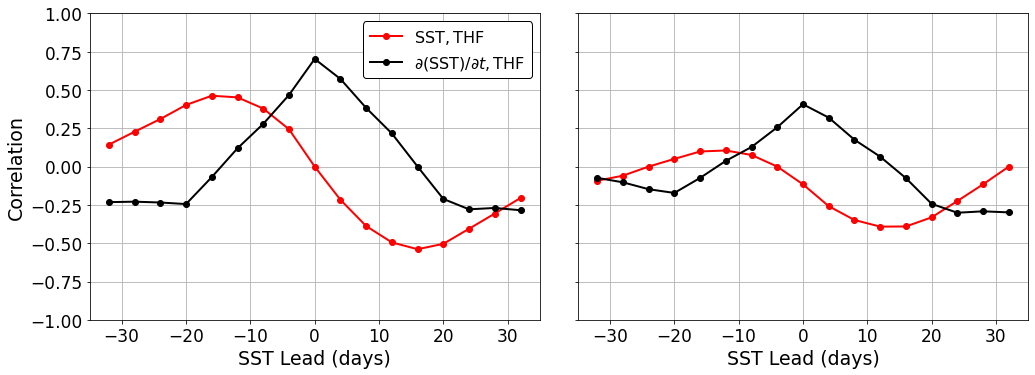

In [45]:
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=17) 

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,5))
fig.tight_layout()
axs.flatten()

xdata=[lag*days_in_1lag for lag in lags]

xmax = 35; xmin = -xmax
ymax = 1; ymin = -ymax

lw=2

locs=[(325,125), (300,410)]

(jpos,ipos)=(locs[0][0],locs[0][1])

axs[0].plot(xdata,da_sstthf_cor[:,jpos,ipos],'ro-',label=r'${\rm SST},{\rm THF}$',linewidth=lw);
axs[0].plot(xdata,da_dsstdtthf_cor[:,jpos,ipos],'ko-',
            label=r'$\partial {\rm (SST)}/\partial t, {\rm THF}$',linewidth=lw);
axs[0].grid(True)
axs[0].set_ylim(ymin,ymax)
axs[0].set_yticks(np.arange(-1,1.25,0.25))
axs[0].set_xlabel('SST Lead (days)',fontdict={'fontsize':19})
axs[0].set_ylabel('Correlation',fontdict={'fontsize':19})
axs[0].set_xlim(xmin,xmax)
leg=axs[0].legend(fontsize=16,loc='upper right',edgecolor='k',framealpha=1)

(jpos,ipos)=(locs[1][0],locs[1][1])

axs[1].plot(xdata,da_sstthf_cor[:,jpos,ipos],'ro-',linewidth=lw);
axs[1].plot(xdata,da_dsstdtthf_cor[:,jpos,ipos],'ko-',linewidth=lw);
axs[1].grid(True)
axs[1].set_ylim(ymin,ymax)
axs[1].set_xlabel('SST Lead (days)',fontdict={'fontsize':19})
axs[1].set_xlim(xmin,xmax)

fig.set_facecolor("w")

#### <b> Plot 2: Spatial map of lead-lag correlations between SST and THF at lead and lag of 1 week </b>
#### <b> Note how the correlation between SST and THF is anti-symmetric about zero lead (middle panel) throughout the GoM, consistent with the earlier plot.

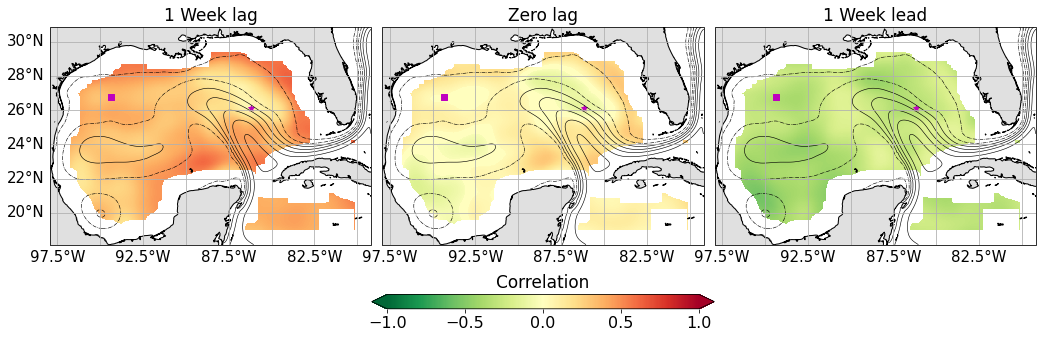

In [37]:
fig,axs=plt.subplots(1,3,sharey=True,figsize=(14,4),subplot_kw=dict(projection=proj))
axs.flatten()
fig.tight_layout()

mpl.rcParams["contour.negative_linestyle"]='dashdot'

cmax=1; cmin = -cmax;
levs=np.arange(-0.6,0.7,0.1)

lw=0.6
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('figure',titlesize=16)
mpl.rcParams['lines.linewidth'] = 1
mark=['s','*']


ax1 = plt.subplot(1, 3, 1, projection=proj)
rminus.cf.plot(ax=ax1,vmin=cmin,vmax=cmax,
               cmap=plt.cm.RdYlGn_r,add_colorbar=False)
ssh_mean.cf.plot.contour(ax=ax1,x='longitude',y='latitude',colors='k',levels=levs,linewidths=lw)
ax1.set_title('1 Week lag',fontsize=17)
gl=ax1.gridlines(xformatter=LONGITUDE_FORMATTER,yformatter=LATITUDE_FORMATTER,draw_labels=True)
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False

ax2 = plt.subplot(1, 3, 2, projection=proj)
r0.cf.plot(ax=ax2,vmin=cmin,vmax=cmax,cmap=plt.cm.RdYlGn_r,add_colorbar=False)
ssh_mean.cf.plot.contour(ax=ax2,x='longitude',y='latitude',colors='k',levels=levs,linewidths=lw)
gl=ax2.gridlines(xformatter=LONGITUDE_FORMATTER,yformatter=LATITUDE_FORMATTER,draw_labels=True)
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}
gl.left_labels = False; gl.right_labels = False
gl.top_labels = False
ax2.set_title('Zero lag',fontsize=17)

ax3 = plt.subplot(1, 3, 3, projection=proj)
rplus.cf.plot(ax=ax3,vmin=cmin,vmax=cmax,cmap=plt.cm.RdYlGn_r,add_colorbar=False)
ssh_mean.cf.plot.contour(ax=ax3,x='longitude',y='latitude',colors='k',levels=levs,linewidths=lw)
ax3.set_title('1 Week lead',fontsize=17)
gl=ax3.gridlines(xformatter=LONGITUDE_FORMATTER,yformatter=LATITUDE_FORMATTER,draw_labels=True)
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}
gl.left_labels = False; gl.right_labels = False
gl.top_labels = False

for ax in [ax1,ax2,ax3]:
    ax.add_feature(cf.COASTLINE) 
    ax.add_feature(cf.LAND, color="lightgrey", alpha=0.7)

    for i in range(len(locs)):
        ax.scatter(ds.lon_rho[locs[i][0],locs[i][1]],
                   ds.lat_rho[locs[i][0],locs[i][1]],color='m',marker=mark[i])

norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
cax = fig.add_axes([0.33, -0.1, 0.34, 0.05])
cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.RdYlGn_r, norm=norm,
                               orientation='horizontal',extend='both')
cb.ax.tick_params(labelsize=16.0)
cb.set_ticks(np.arange(-1,1.5,0.5))
cb.ax.set_title(r'Correlation',fontdict={'fontsize':17});

fig.set_facecolor("w")